In [129]:
import numpy as np
import sklearn.preprocessing
from matplotlib import pyplot as plt
import neurokit2 as nk

save_figures = False
ecg_sampling_rate=256
ecg_plot_starttime_sec=10
ecg_plot_duration_sec=3
ecg_sampling_rate=256

ecg_data_filepath = './sample_ecg.csv';

# Load the ECG Signal Data...
ecg_data = np.loadtxt(ecg_data_filepath, delimiter=',', dtype=float)

# Note -- if you don't have a dataset yet and just want to play with filters, you 
#         can generate a simulated ECG for this example like so:
###########################################################################################################
# ecg_data = nk.ecg_simulate(duration=30, sampling_rate=ecg_sampling_rate, noise=.01, heart_rate=89)
# sim_ts = np.arange(len(ecg_data))/ecg_sampling_rate
# ecg_data = ecg_data * 0.9 + .1 * np.sin(2*np.pi*50*sim_ts)               # Add powerline noise at 50hz
# ecg_data = ecg_data * 0.9 + 1 + 0.25 * np.sin(2*np.pi*0.1*sim_ts)       # Add baseline wander
# ecg_data = np.array([
#     ecg_data,
#     sim_ts,
# ]).reshape(-1,2)

# The ECGs are two-channels, let's arbitarily use Channel 1 (column 0) for this example...
channel_data = ecg_data[:, 1]

# The signal is sampled at 256 Hz, therefore each datapoint happens 1/256 seconds after
# the last. Let's build an array with the timestep for each sample so we can plot against
# time in seconds, rather than against sample #.
timesteps = (np.arange(start=0, stop=len(channel_data), step=1)) / ecg_sampling_rate

# Used to index into the signal and timesteps to extract a small sample for plots
start_sample_num = ecg_sampling_rate*ecg_plot_starttime_sec
end_sample_num = ecg_sampling_rate*(ecg_plot_starttime_sec + ecg_plot_duration_sec)

# Used for plotting new figures each time ...
fignum=1

plt.rcParams['figure.figsize'] = [12, 9] 


In [130]:
###
# We use Neurokit2 for signal analysis and filtering ... you can do your filtering with scikit learn very easily too, 
# NK really just wraps SKLearn in some convenient methods designed for physiological signal processing.
####################################################################################################

# Process the data using Elgendi2010 ... why Elgendi2010? Because I got the best results with it.
processed, info = nk.ecg_process(channel_data, ecg_sampling_rate, "elgendi2010")

# Extract the ECG_Clean and ECG_Raw signals from the processed signal set... ECG_Raw is unmodified, we can 
# just as well continue to use channel_data ... but I like consistency.
#
# Note -- I pass the signals through nk.ecg_invert ... this method will make sure our signal is "right side 
# up", especially since Elgendi2010 inverts the signal during processing (something I haven't looked into yet)
raw, is_raw_inverted = nk.ecg_invert(processed['ECG_Raw'], 256)
clean, is_clean_inverted = nk.ecg_invert(processed['ECG_Clean'], 256)

# Now "clean" is our fully processed, ready to go ECG Signal ... we can just use this instead of doing it step-by-step below, but
# that's no fun ... let's dig in. "raw" is our original signal, and is just a copy of channel_data

In [131]:
def plot_signal( signal_data, title, xlabel, ylabel, figsize=(12,8), start=start_sample_num, end=end_sample_num ):
    global timesteps
    global fignum
    global start_sample_num
    global end_sample_num
    global save_figures
    
    plt.figure(fignum,figsize)
    plt.title(title)
    plt.plot(timesteps[start:end], signal_data[start:end])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if save_figures:
        plt.savefig(f'./figure_{fignum}.png', transparent=True)
    plt.show()
    fignum += 1
    
    
def plot_histogram( data, weights, num_bins, title, xlabel, ylabel, figsize=(10,6) ):
    global timesteps
    global fignum
    global save_figures
    
    plt.figure(fignum,figsize=figsize)
    plt.hist(data, bins=np.linspace(0, ecg_sampling_rate/2, num_bins), weights=weights, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    if save_figures:
        plt.savefig(f'./figure_{fignum}.png', transparent=True)
    plt.show()
    fignum += 1
    
    
def plot_in_frequency_domain(signal):
    n=len(signal)
    fft_result = np.fft.fft(signal)                        # Perform an FFT Transform of the raw signal to convert it to the frequency domain
    fft_freqs = np.fft.fftfreq(n, d=1/ecg_sampling_rate)   # Generate the frequencies corresponding to the FFT results
    positive_freqs = fft_freqs[:n//2]                      # FFT is symmetric, so let's just take the positive frequencies
    positive_magnitude = np.abs(fft_result[:n//2])         #    and magnitudes.              
    
    # Here we will plot a histogram showing how often specific frequency components occur within the ECG signal's frequency domain
    # It is weighted on the magnitude of each frequency component so we can see how heavily each frequency component contributes
    # to the overall signal ...
    plot_histogram(positive_freqs, positive_magnitude, 60, 
                   title="Histogram of Frequency Occurrences in the ECG Signal",
                   xlabel="Frequency (Hz)",
                   ylabel="Count (Weighted by Magnitude)")
    
def center_and_rescale(signal):
    x = np.array(signal)
    x = StandardScaler().fit_transform(x.reshape(-1,1)).flatten()   # Standardize to mean 0 and unit scale
    x = x / np.max(np.abs(x))                                       # Rescale to [-1,1]
    return x


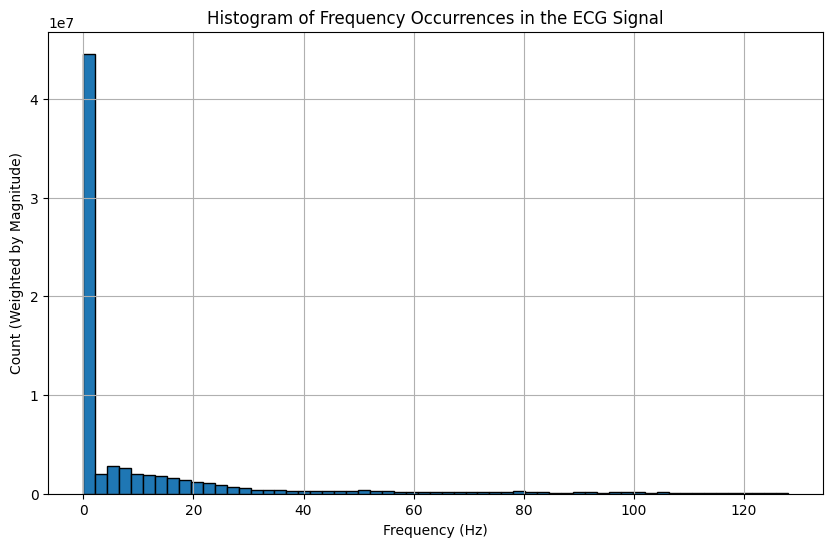

In [132]:
###
# Let's first analyze the frequency domain of the signal ... it's useful to know how much each 
# frequency range contributes to the signal data when preparing to filter certain frequencies out...
####################################################################################################

plot_in_frequency_domain(raw)



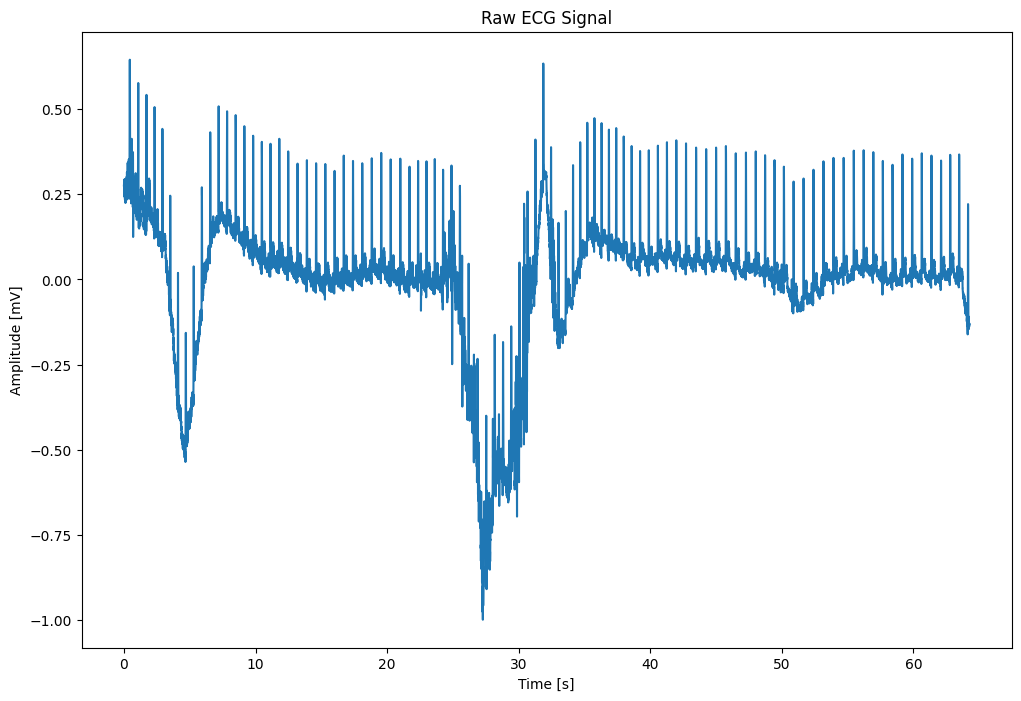

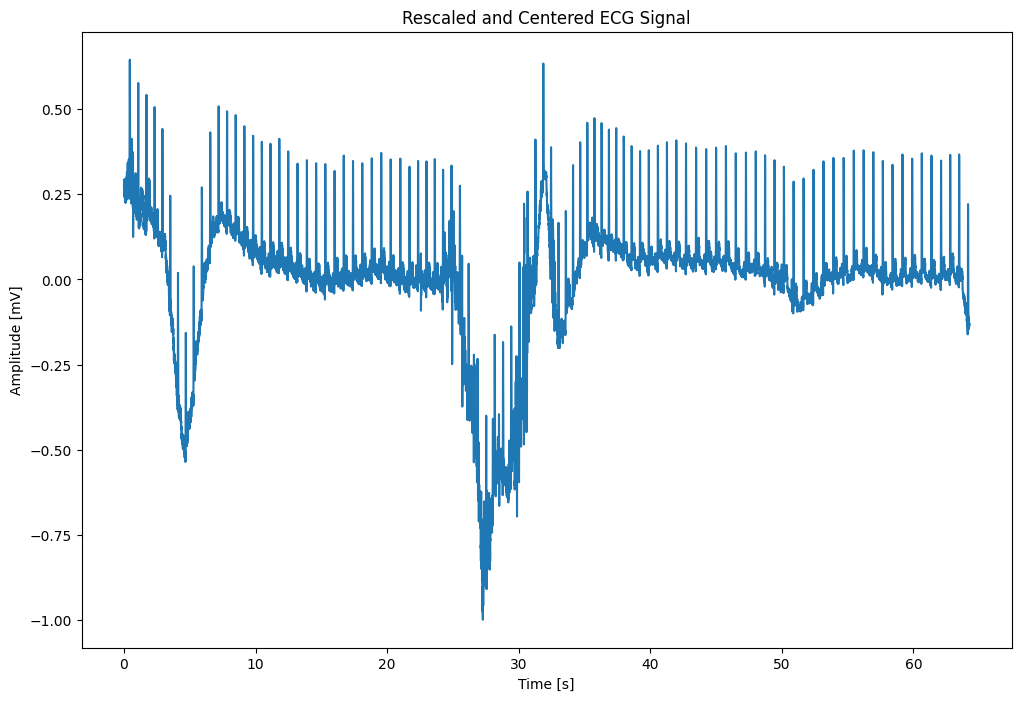

In [139]:
# Plot the raw ecg signal 

plot_signal(raw, 
            title=f'Raw ECG Signal',
            xlabel='Time [s]',
            ylabel='Amplitude [mV]',
            start=0,end=len(raw))

# Center and Rescale both raw and clean. We use clean at the end.
raw_recentered = center_and_rescale(raw)
plot_signal(raw, 
            title=f'Rescaled and Centered ECG Signal',
            xlabel='Time [s]',
            ylabel='Amplitude [mV]',
            start=0,end=len(raw_recentered))



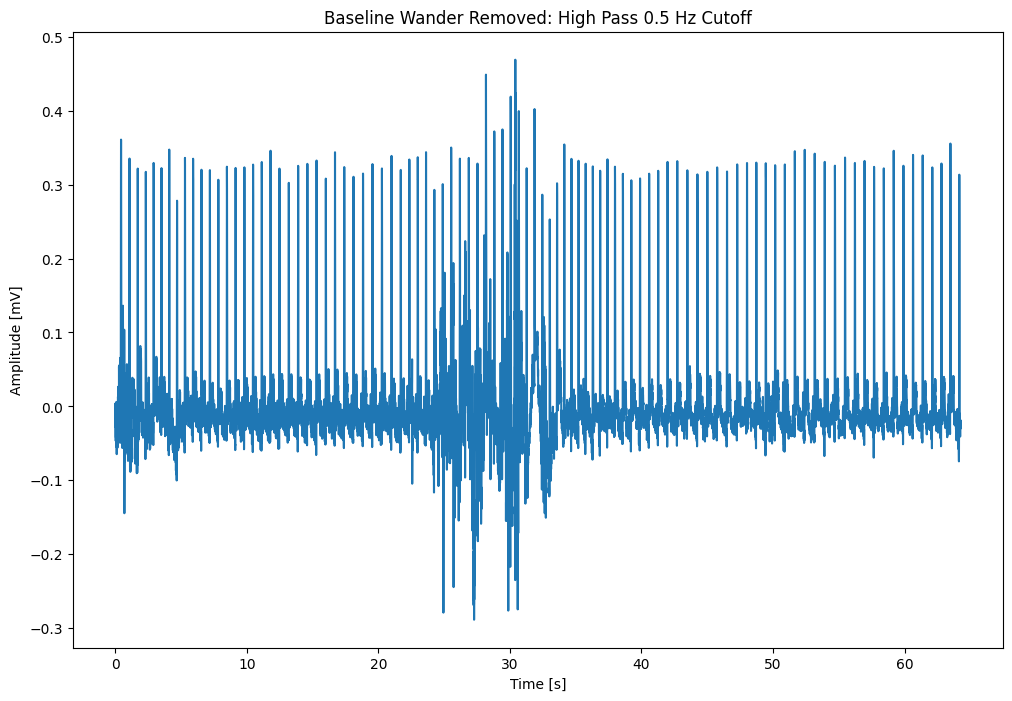

In [134]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Let's remove baseline wander from the signal ... baseline wander is low frequency noise so we use a high pass butterworth filter to 
# remove it. We'll use a cutoff of 0.5Hz ... typical range for the cutoff is 0.5 to 0.7 Hz, but moving above 0.5Hz may remove useful 
# data from the ECG and we want to be careful of that ... 

baseline_wander_removed = nk.signal_filter(signal=raw, 
                                           sampling_rate=ecg_sampling_rate, 
                                           lowcut=0.5, 
                                           highcut=None, 
                                           method="butterworth", 
                                           order=2)



plot_signal(baseline_wander_removed, 
            title='Baseline Wander Removed: High Pass 0.5 Hz Cutoff',
            xlabel='Time [s]',
            ylabel='Amplitude [mV]', start=0,end=len(clean))


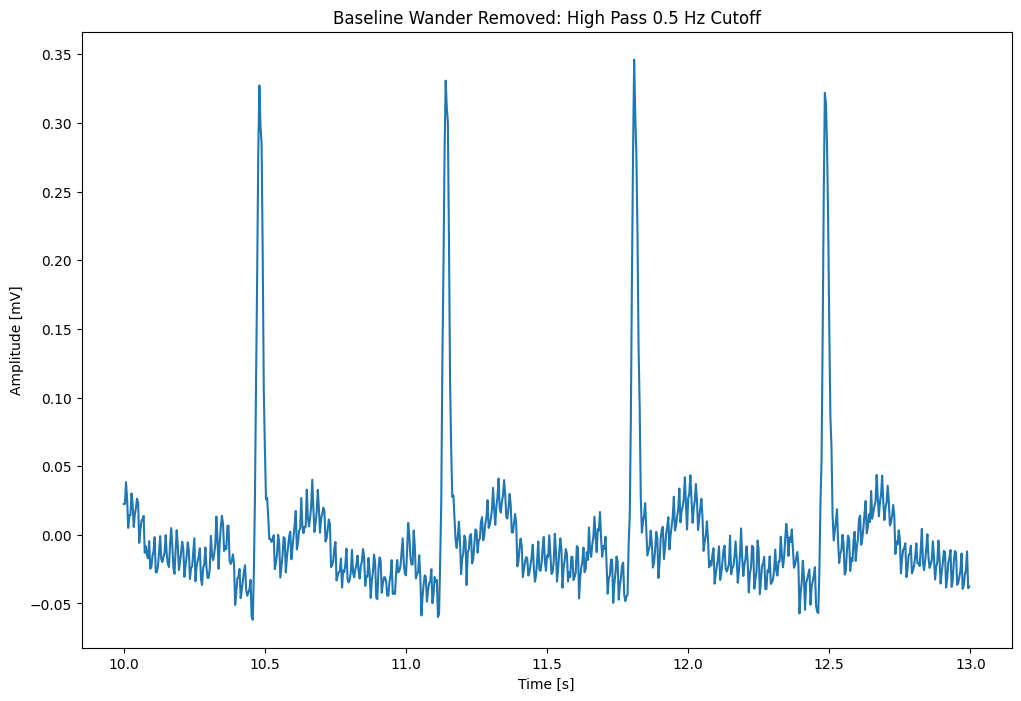

In [135]:
plot_signal(baseline_wander_removed, 
            title='Baseline Wander Removed: High Pass 0.5 Hz Cutoff',
            xlabel='Time [s]',
            ylabel='Amplitude [mV]')

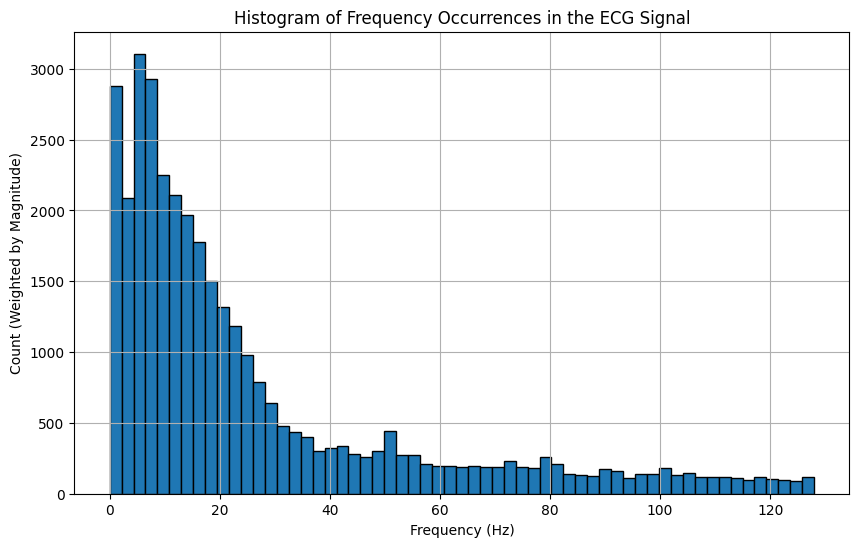

In [136]:
###
# Our frequency domain graph of the raw signal was very heavy in low-frequency signals ... let's see if that's changed 
# after removing baseline wander...
#########################################################################################################################

plot_in_frequency_domain(baseline_wander_removed)


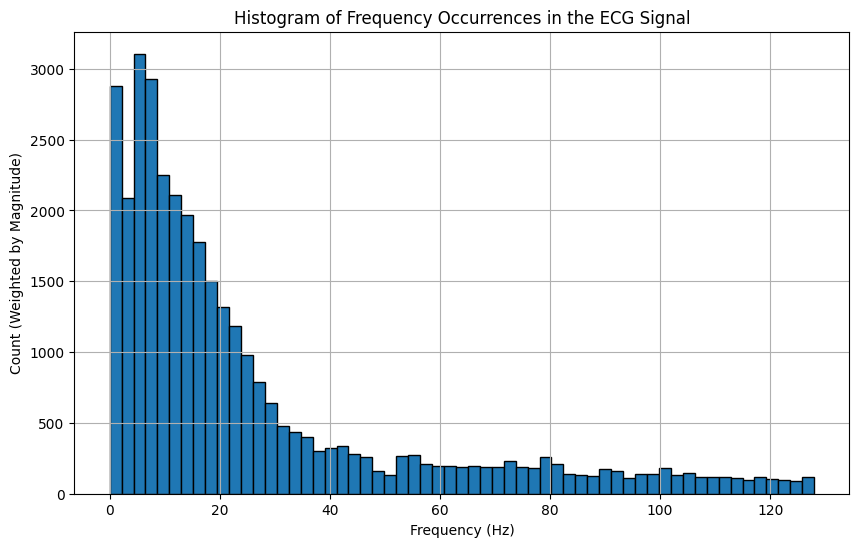

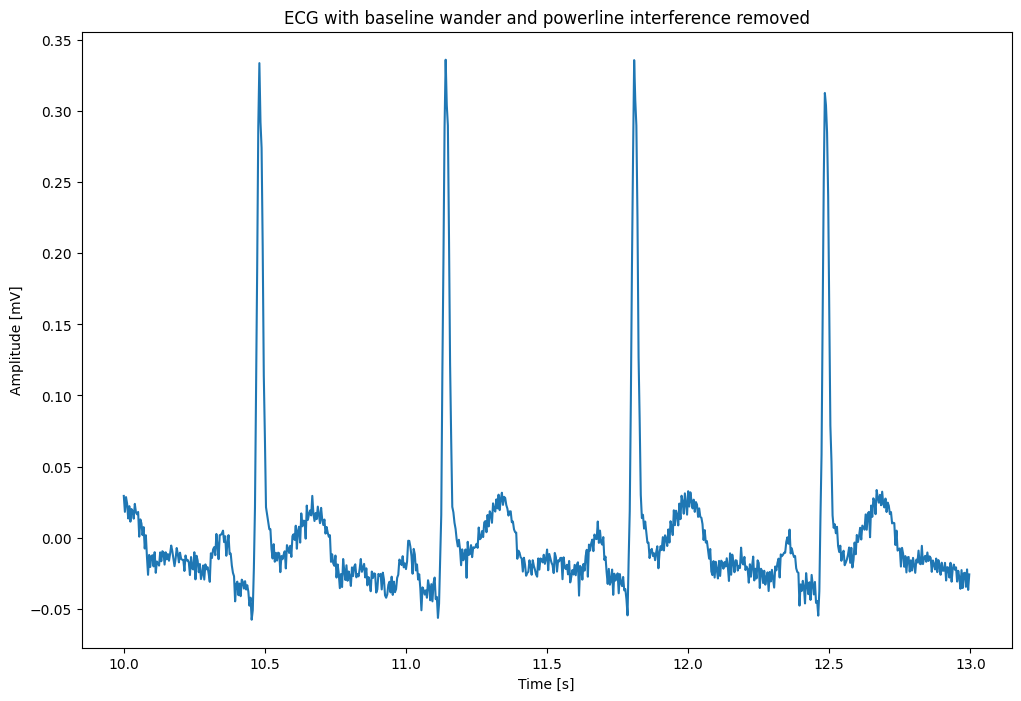

In [137]:
###
# We can see a brief spike around 50Hz (or a multiple thereof)... 
# 
# That's powerline interference in Europe, Asia, Africa, and parts of South America. 
# North America and parts of South America use 60Hz, so if the data were recorded at Clarkson U, 
# we'd see that spike around 60 instead.
#
# Let's get rid of that using a bandpass filter
####################################################################################################################

powerline_interference_removed = nk.signal_filter(
    signal=baseline_wander_removed,
    method='butterworth_ba',
    lowcut=51,
    highcut=49,
    order=2,
    sampling_rate=ecg_sampling_rate,
)

# Note - this is only happening in the simulated signal where the powerline interference is at
#   100 Hz instead of 50 ... not going to look into this too carefully.
# powerline_interference_removed = nk.signal_filter(
#     signal=powerline_interference_removed,
#     method='butterworth_ba',
#     lowcut=101,
#     highcut=99,
#     order=2,
#     sampling_rate=ecg_sampling_rate,
# )


plot_in_frequency_domain(powerline_interference_removed)
plot_signal(powerline_interference_removed,
            title="ECG with baseline wander and powerline interference removed",
            xlabel='Time [s]',
            ylabel='Amplitude [mV]')

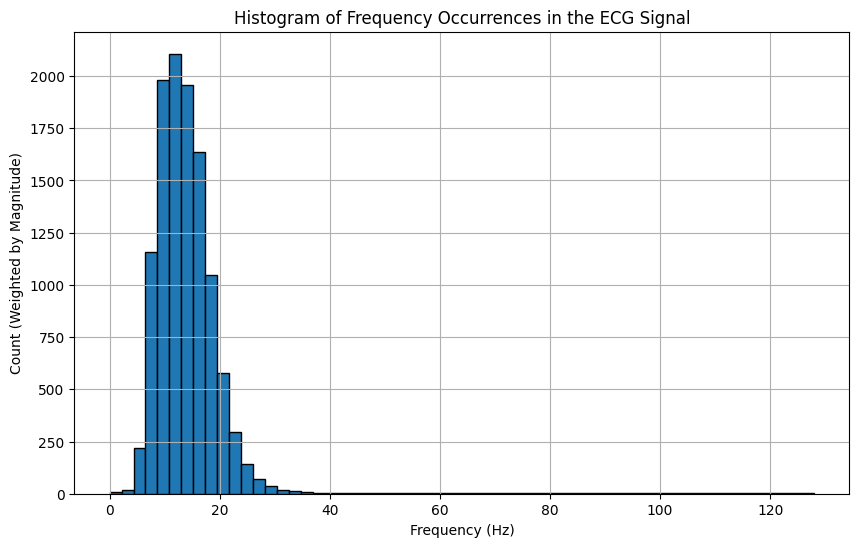

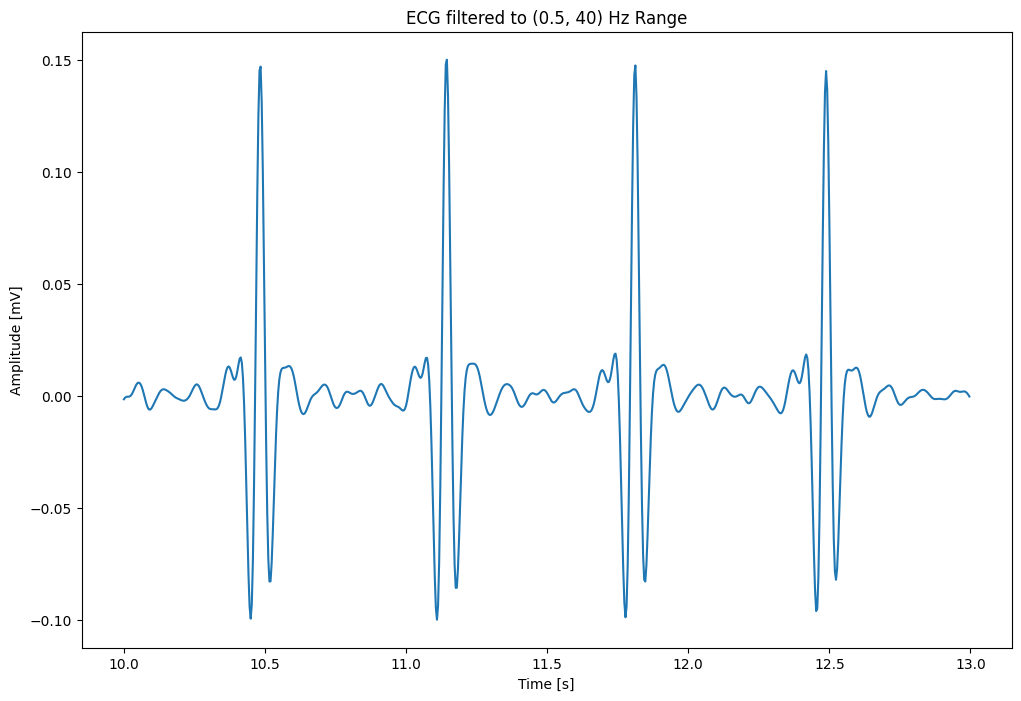

NameError: name 'pqrst_complex' is not defined

In [138]:
# PQRST Complex is actually typically found in the 0.5 to 40Hz range ...
#    P-Wave is between 0.5 and 10 Hz
#    QRS-Complex is between 10 and 40 Hz
#    T-Wave is usually between 1 and 7 Hz

low_cutoff = 8
high_cutoff = 20

final_signal = nk.signal_filter(
    powerline_interference_removed,
    sampling_rate=ecg_sampling_rate,
    lowcut=low_cutoff, highcut=high_cutoff, method="butterworth_ba", order=2
)
final_signal, pqrst_is_inverted = nk.ecg_invert(final_signal, sampling_rate=ecg_sampling_rate)

plot_in_frequency_domain(final_signal)
plot_signal(final_signal,
            title="ECG filtered to (0.5, 40) Hz Range",
            xlabel='Time [s]',
            ylabel='Amplitude [mV]')

plt.rcParams['figure.figsize'] = [12, 9] 
qrs_epochs = nk.ecg_segment(pqrst_complex, rpeaks=None, sampling_rate=ecg_sampling_rate, show=True)


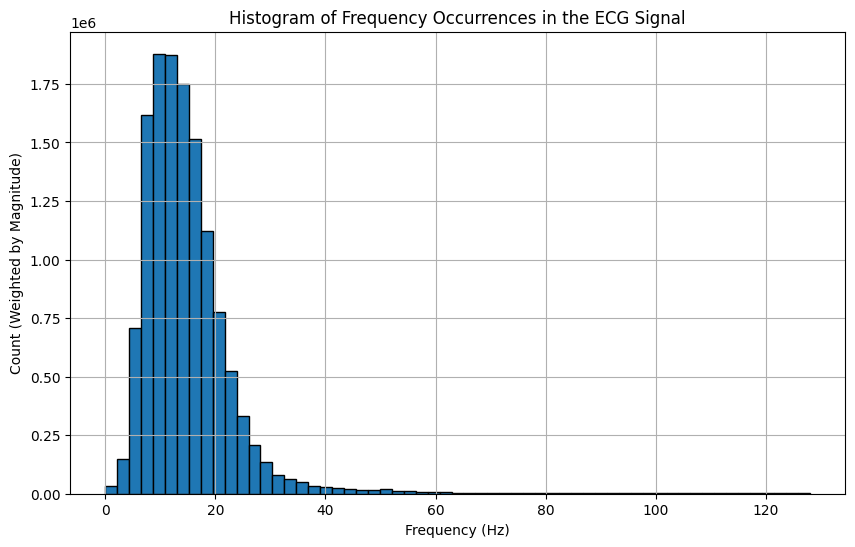

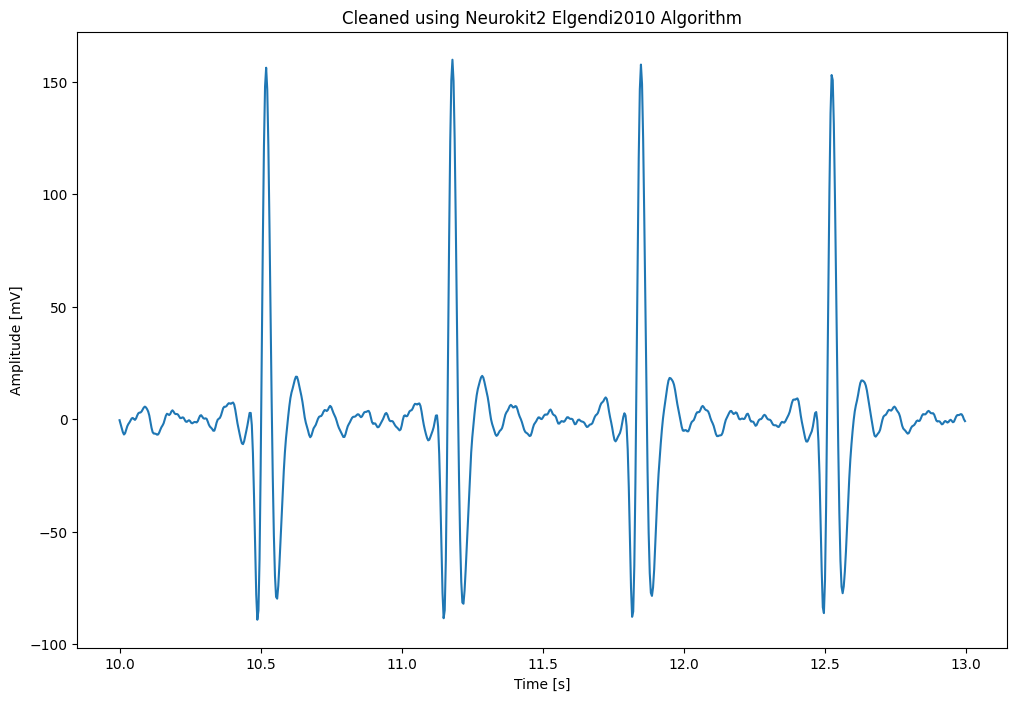

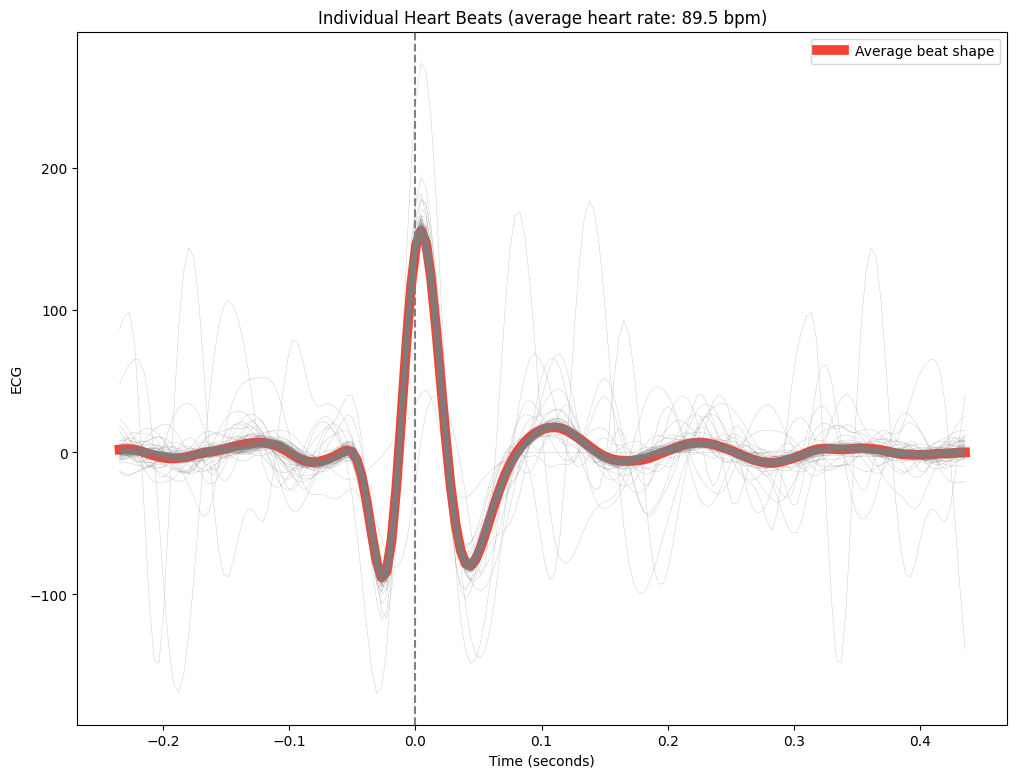

In [76]:
###
# Remember way back at the top when we "cleaned" the ECG and then just ignored the cleaned signal?
# Well here it is...
##################################################################################################
plot_in_frequency_domain(clean)
plot_signal(clean,
            title='Cleaned using Neurokit2 Elgendi2010 Algorithm',
            xlabel='Time [s]',
            ylabel='Amplitude [mV]');

qrs_epochs = nk.ecg_segment(clean, rpeaks=None, sampling_rate=ecg_sampling_rate, show=True)

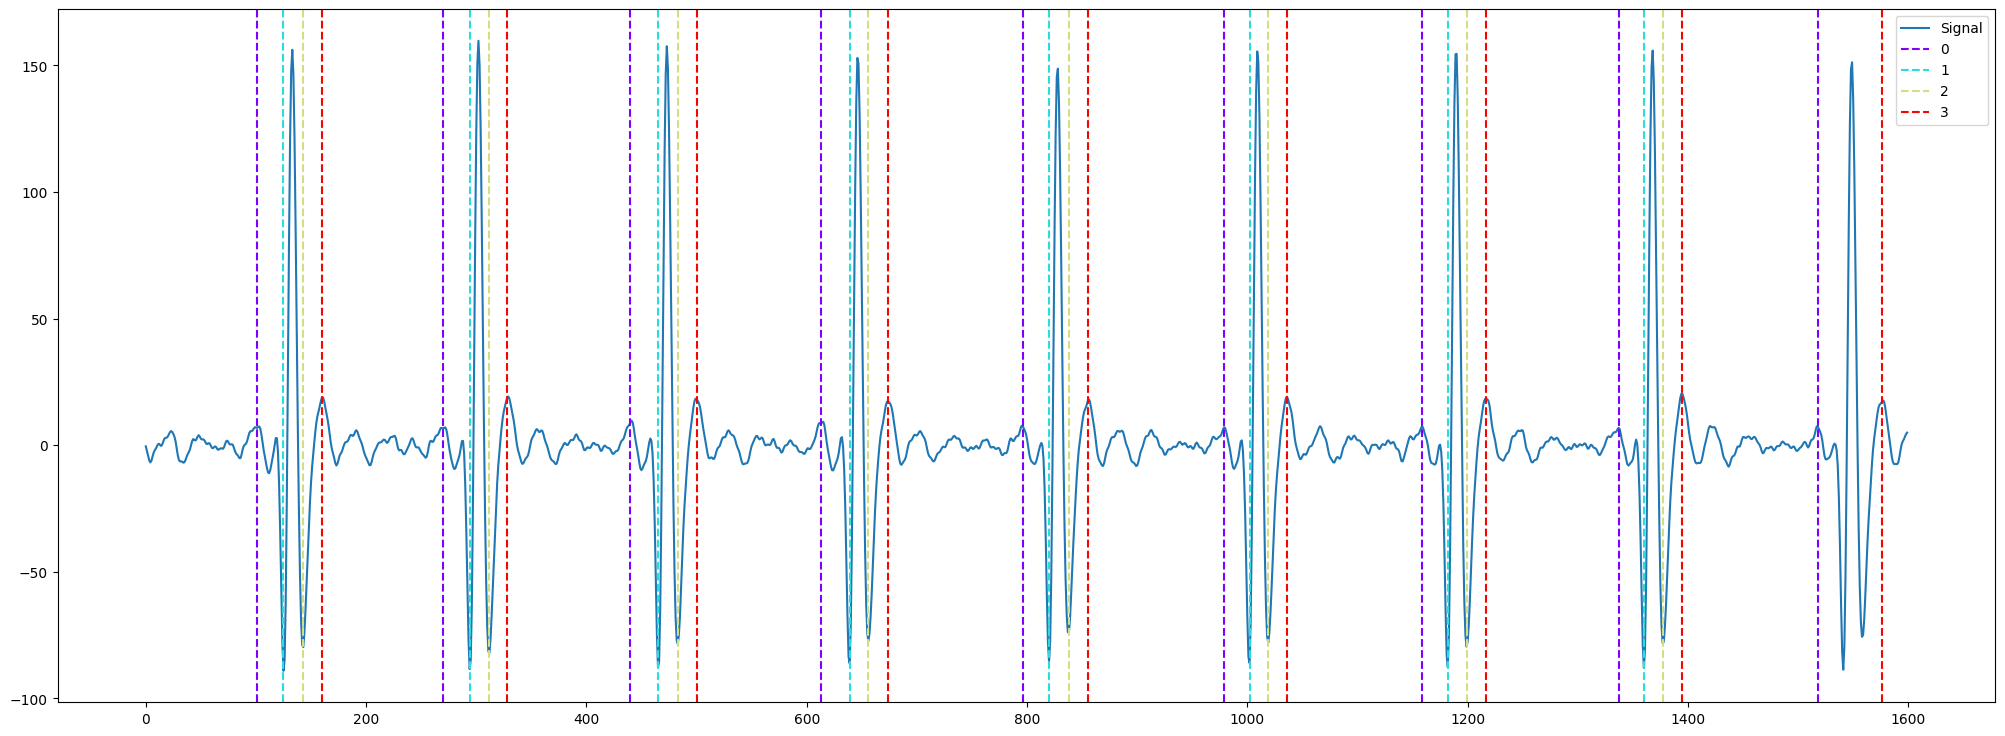

In [12]:
import math
clean_sample = clean[start_sample_num:math.ceil(1.25*end_sample_num)]
_, rpeaks = nk.ecg_peaks(clean_sample, sampling_rate=ecg_sampling_rate)
signals, waves = nk.ecg_delineate(clean_sample, rpeaks, sampling_rate=ecg_sampling_rate)
plt.rcParams['figure.figsize'] = [25, 9] 
nk.events_plot([waves["ECG_P_Peaks"], waves["ECG_Q_Peaks"], waves["ECG_S_Peaks"], waves["ECG_T_Peaks"]], clean_sample)

## Fun With Feature Extraction...
Let's extract some features from the ecg ...

/home/timcsf/.conda/envs/aer2023_tf215/lib/python3.10/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
/home/timcsf/.conda/envs/aer2023_tf215/lib/python3.10/site-packages/neurokit2/hrv/hrv_nonlinear.py:529: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Heart Rate (Mean): 89.48005107327283
Heart Rate Variability: 32.155684571086574


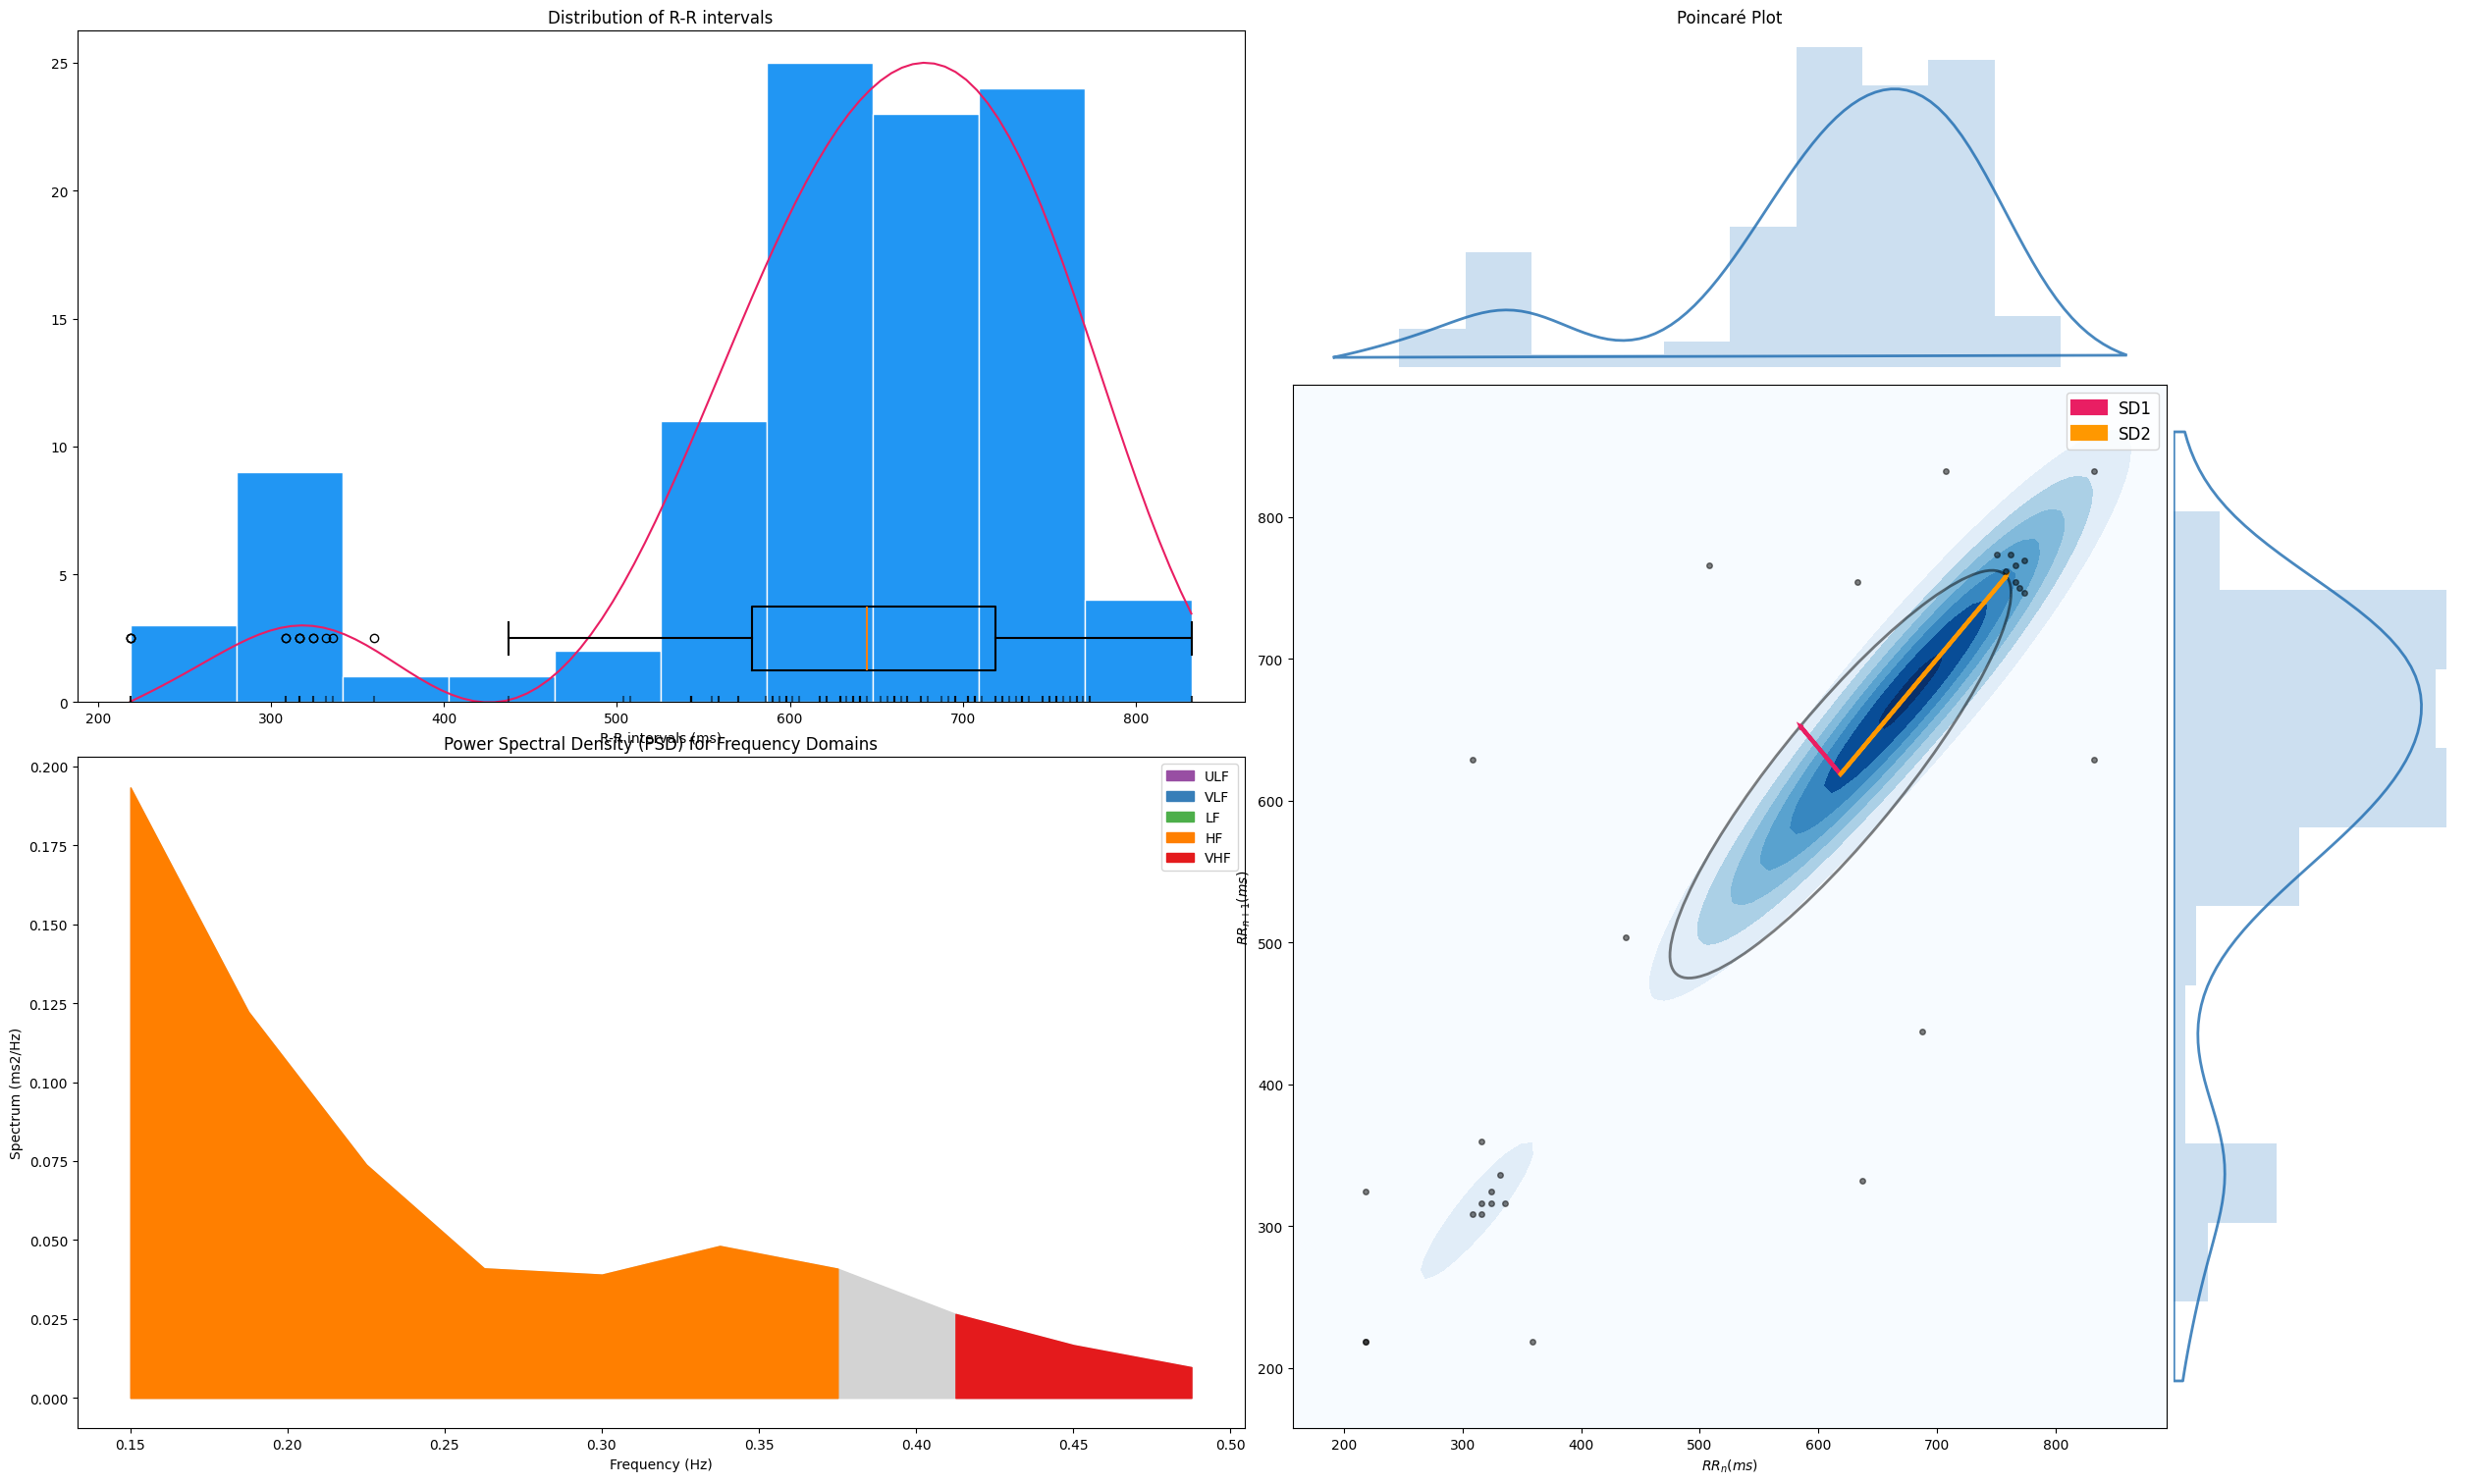

In [45]:
r_peaks = info['ECG_R_Peaks']
peaks, info = nk.ecg_peaks(clean, sampling_rate=100, correct_artifacts=True)

plt.rcParams['figure.figsize'] = [25, 15] 

hrv_indices = nk.hrv(peaks, sampling_rate=ecg_sampling_rate, show=True)
analyze_df = nk.ecg_analyze(processed, sampling_rate=ecg_sampling_rate)

print(f'Heart Rate (Mean): {analyze_df.ECG_Rate_Mean[0]}')
print(f'Heart Rate Variability: {analyze_df.HRV_RMSSD[0][0][0]}')

# ibi = np.diff(r_peaks) / ecg_sampling_rate * 1000  # Convert to milliseconds
# hrv=nk.hrv(r_peaks, sampling_rate=ecg_sampling_rate, show=True)
# nk.ecg_intervalrelated(clean, sampling_rate=100)

# print(f'Heart Rate Variability: {hrv} ms')

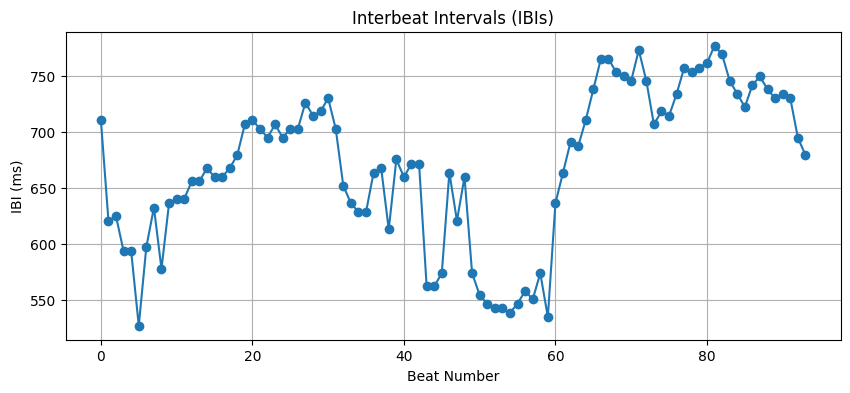

In [17]:
plt.figure(figsize=(10, 4))
plt.plot(ibi, marker='o', linestyle='-')
plt.title('Interbeat Intervals (IBIs)')
plt.xlabel('Beat Number')
plt.ylabel('IBI (ms)')
plt.grid(True)
plt.show()